# Estimation of MODIS-like Surface-Spectral Reflectance from Geostationary Satellites using Deep Neural Networks 

## Setup

In [22]:
%matplotlib inline
import argparse
import datetime
import glob
import os

import gdal
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.ndimage

In [23]:
raw_dir = "modis"
layers = ["250m 16 days composite day of the year", # doy 1st for compositing reasons
          "250m 16 days NDVI", 
          "250m 16 days NIR reflectance"] 
raw_files = glob.glob(raw_dir + '/*.hdf')
raw_files[:5]

['modis/MOD13Q1.A2016225.h23v11.005.2016243094838.hdf',
 'modis/MOD13Q1.A2016225.h31v06.005.2016243093313.hdf',
 'modis/MOD13Q1.A2016225.h32v09.005.2016243095547.hdf',
 'modis/MOD13Q1.A2016225.h26v03.005.2016243101730.hdf',
 'modis/MOD13Q1.A2016225.h25v05.005.2016243103211.hdf']

In [24]:
filepath = [f for f in raw_files if 'h30v11' in f][0] # set day here
day_of_year = 225 # int(filepath.split('.')[4][4:7])
filepath, day_of_year

('modis/MOD13Q1.A2016225.h30v11.005.2016243103650.hdf', 225)

In [25]:
ds = gdal.Open(filepath, gdal.GA_ReadOnly)
datasets = ds.GetSubDatasets()
datasets[:2]

[('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2016225.h30v11.005.2016243103650.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days NDVI',
  '[4800x4800] 250m 16 days NDVI MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2016225.h30v11.005.2016243103650.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days EVI',
  '[4800x4800] 250m 16 days EVI MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)')]

## Day of Year

In [26]:
doy_layer = ""
for dataset in datasets:
    if layers[0] in dataset[0]:
        doy_layer = dataset[0]
file_type = doy_layer.split(' ')[3].lower()
doy_layer, file_type

('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2016225.h30v11.005.2016243103650.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days composite day of the year',
 'composite')

In [27]:
doy_modis = gdal.Open(doy_layer)
doy_modis.ReadAsArray()

array([[229, 229, 229, ..., 230, 230, 230],
       [229, 236, 229, ..., 230, 228, 230],
       [229, 229, 229, ..., 226, 228, 230],
       ..., 
       [239, 225, 228, ..., 227, 229, 227],
       [225, 228, 228, ..., 227, 227, 229],
       [230, 228, 228, ..., 227, 229, 229]], dtype=int16)

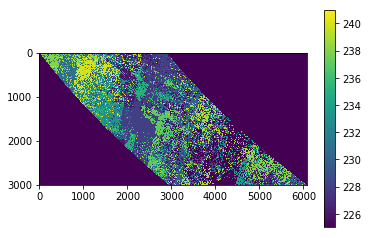

In [28]:
output = filepath.replace('.hdf', '.' + file_type + ".tif")
gdal.Warp(output, doy_modis, dstSRS='EPSG:3857')
data = gdal.Open(output)
doy_arr = data.ReadAsArray()
plt.imshow(doy_arr)
plt.clim(day_of_year, day_of_year + 16)
_ = plt.colorbar()


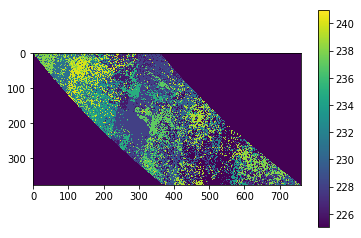

In [30]:
resized_doy = scipy.ndimage.zoom(doy_arr, 0.125, order=0)
plt.imshow(resized_doy)
plt.clim(day_of_year, day_of_year + 16)
_ = plt.colorbar()

## Near Infrared

In [31]:
nir_layer = ""
for dataset in datasets:
    if layers[2] in dataset[0]:
        nir_layer = dataset[0]
        
file_type = nir_layer.split(' ')[3].lower()
nir_layer, file_type

('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2016225.h30v11.005.2016243103650.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days NIR reflectance',
 'nir')

In [32]:
nir_modis = gdal.Open(nir_layer)
nir_modis.ReadAsArray()

array([[2591, 2540, 2666, ..., 2199, 2145, 2103],
       [2599, 2560, 2639, ..., 2365, 1803, 2132],
       [2781, 2749, 2636, ..., 1744, 1823, 2181],
       ..., 
       [2652, 2966, 2465, ..., 2121, 2557, 2235],
       [2986, 2544, 2471, ..., 1448, 1564, 1694],
       [2545, 2469, 2463, ..., 1402, 1606, 1452]], dtype=int16)

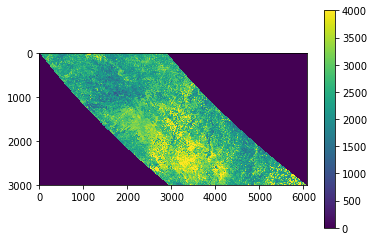

In [33]:
output = filepath.replace('.hdf', '.' + file_type + ".tif")
gdal.Warp(output, nir_modis, dstSRS='EPSG:3857')
data = gdal.Open(output)
nir_arr = data.ReadAsArray()
plt.imshow(nir_arr)
plt.clim(0,4000)
_ = plt.colorbar()

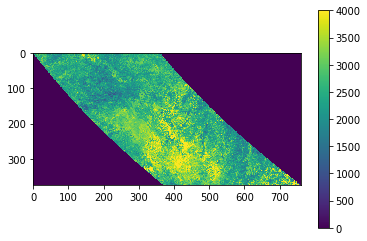

In [34]:
# resize using nn
resized_nir = scipy.ndimage.zoom(nir_arr, 0.125, order=0)
resized_nir.shape, nir_arr.shape
plt.imshow(resized_nir)
plt.clim(0,4000)
_ = plt.colorbar()

In [35]:
doy = int(filepath.split('.')[1][5:])
year = int(filepath.split('.')[4][0:4])
date = datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1)

In [36]:
# Find closest goes-16 times
modis_time = filepath.split('.')[4][7:]
_time = datetime.datetime.strptime(modis_time, "%H%M%S")